<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Thoughts" data-toc-modified-id="Thoughts-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Thoughts</a></span><ul class="toc-item"><li><span><a href="#Augmentation" data-toc-modified-id="Augmentation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Augmentation</a></span></li></ul></li><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download Data</a></span></li><li><span><a href="#Scene-Data" data-toc-modified-id="Scene-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scene Data</a></span><ul class="toc-item"><li><span><a href="#Superpixels" data-toc-modified-id="Superpixels-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Superpixels</a></span></li></ul></li><li><span><a href="#VQATools-Demo" data-toc-modified-id="VQATools-Demo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>VQATools Demo</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Baselines" data-toc-modified-id="Baselines-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Baselines</a></span><ul class="toc-item"><li><span><a href="#Baseline-3:-Img-+-Question-+-Given-Objects" data-toc-modified-id="Baseline-3:-Img-+-Question-+-Given-Objects-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Baseline 3: Img + Question + Given Objects</a></span></li><li><span><a href="#Baseline-2:-LSTM(Question)-+-LSTM(Given-Objects-Embedded)" data-toc-modified-id="Baseline-2:-LSTM(Question)-+-LSTM(Given-Objects-Embedded)-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Baseline 2: LSTM(Question) + LSTM(Given Objects Embedded)</a></span></li><li><span><a href="#Baseline-1:-LSTM(Question)-+-LSTM(Given-Objects)" data-toc-modified-id="Baseline-1:-LSTM(Question)-+-LSTM(Given-Objects)-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Baseline 1: LSTM(Question) + LSTM(Given Objects)</a></span></li></ul></li><li><span><a href="#New-Models" data-toc-modified-id="New-Models-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>New Models</a></span><ul class="toc-item"><li><span><a href="#Soft-crop-testing" data-toc-modified-id="Soft-crop-testing-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Soft crop testing</a></span></li></ul></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Comparison</a></span></li></ul></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle

from tf_layers.layers import EmbeddingLayer, ConvLayer, FlattenLayer, LSTMLayer, DenseLayer,\
    BranchedLayer, MergeLayer, CustomLayer, LayerModule, GlobalAvgPoolLayer, add_implied_layers
from tf_layers.models import NN, get_inputs_from_spec

import sys
sys.path.append('VQA/PythonHelperTools/vqaTools/')
from vqa import VQA

from tf_layers.tf_utils import tf_init

config = tf_init()

%matplotlib inline

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [1]:
tf

NameError: name 'tf' is not defined

# Thoughts
A vector for each object + a vector for the scene
* composed of the information we already have (object name, x, y, etc.) + image information
    * What should that part look like? Consider having a base CNN, then train one additional conv layer for each object type (+ one for the global scene). The output of that layer is flattened and used for the vector.
    * Does it make sense that each object type would have its own conv layer? Or what's another way that we could have each object get potentially different information about the scene that corresponds to relationships about that particular object?
* For each object vector, a key that is used for attention. Maybe do a small dense layer from the object vector to a smaller key vector. When doing a query for attention, query the keys to get the probability distribution but then apply that on the object vectors. Use cosine distance between keys and query.

---

* Want more than just (x,y) for each object; a bounding box/polygon would be nicer. For relations between objects, what else do we need / can we encode?
    * To get bounding boxes (or at least some approximation thereof) maybe try doing some segmentation method? (or superpixels). Then for each object, take whatever region has its (x, y) coord as the segment for that object and make the box around it
* Look at the data more and think about what you, as a human, need in order to answer these questions
    * If you just had a set of boxes for the main objects in the image, could you do it? What additional information would the boxes need to have? (e.g. color)
    * For the more global data (e.g. is this a wintry scene?), could we just run a pre-trained model from Places on the images and use the output from that as additional input?
* How to go from a (variable-sized) graph to a fixed size? Or can you keep it variable by using an RNN over it?
    * Read more about NNs on graphs
    * Fully-connected graph to explicitly represent the connections between all objects; is there any more data you can put on the edges except relative position of the objects? How to encode relative position? dx, dy of the center point or a given corner? dx, dy between all pairs of corners (so, if you have a box for each object, 16 pairs of corners)
* Once we know what objects there are, we can probably do a great deal with textual information. Image data will always be necessary to perform at human level, but how much will low-hanging fruit help? Consider "Is there any healthy food?". For each object, we need to know if it's food and if it's healthy. Maybe store with an object words which are commonly used together with that object? (as, e.g., word embeddings)

---

* Embed the words in a learned embedding; use an LSTM that takes as input at each timestep the result of convolving the current word embedding with the image vector

---

Network to generate dynamic CNN weights based on the objects and the question; use weights generated for each object to get image data for that one (see DPPnet)

## Augmentation
* you can make many more questions if you know about the objects in the images. You can ask "Is there an <object>?", "How many <objects> are there?", "What color is the <object>?", "What is to the left of the <object>?"
    * How well do the sort of questions you could generate automatically match with the real questions?
* What kinds of image augmentation will be good / bad?
    * E.g. if a question asks about left/right, doing an LR flip would be bad

# Download Data
Download links for the VQA dataset are from [here][links]. The GloVe vectors are from [here][glove]; these ones are trained on Wikipedia; they also have a couple of other sets available for download (these are the ones with the smallest vocabulary).

For the VQA tools, you'll need to run `2to3` on any(?) `.py` files that you need to use. If there are space/tab issues, one quick fix is to use `:retab` in `vim`. 

[links]: http://visualqa.org/download.html
[glove]: https://github.com/stanfordnlp/GloVe

In [14]:
%%bash

# get the vqa helper tools to assist with loading the data
if [[ ! -e VQA ]]; then
    echo "Downloading VQA tools"
    git clone https://github.com/VT-vision-lab/VQA.git
fi

mkdir -p data
cd data

# word embeddings
if [[ ! -e glove ]]; then
    echo "Downloading GloVe embeddings"
    mkdir glove
    cd glove
    wget -q http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
    unzip -qq "*.zip"
    rm *.zip
fi

# vqa dataset; getting the images will take some time
# read more on the download page: http://www.visualqa.org/vqa_v1_download.html

# v1: abstract scenes
for split in train val; do
    if [[ ! -e $split ]]; then
        echo "Downloading $split annotations and questions"
        mkdir $split
        cd $split
        wget -q http://visualqa.org/data/abstract_v002/vqa/Annotations_${split^}_abstract_v002.zip
        wget -q http://visualqa.org/data/abstract_v002/vqa/Questions_${split^}_abstract_v002.zip
        wget -q http://visualqa.org/data/abstract_v002/scene_json/scene_json_abstract_v002_${split}2015.zip
        unzip -qq "*.zip"
        rm *.zip

        echo "Downloading $split images"
        mkdir images
        cd images
        wget -q http://visualqa.org/data/abstract_v002/scene_img/scene_img_abstract_v002_${split}2015.zip
        unzip -qq "*.zip"
        rm *.zip

        cd ../..
    fi
done

In [39]:
%%bash
# convert images from png to jpg (lossy compression but saves a lot of space)
# also means we don't have to deal with the transparency channel later and we'll
# be reading in uint8 data instead of float64, so there should be less IO time

for split in train val; do
    for f in data/$split/images/*.png; do
        convert -quality 100 $f ${f%.png}.jpg
        rm $f
    done
done

In [23]:
punctuation = '!@#$%^&*()_+=-{}[]:"\';<>?/.,~%'
def preprocess(string: str) -> str:
    for p in punctuation:
        string = string.replace(p, '')
    return string.strip().lower()

In [24]:
# set up dataframes of questions/answers/img paths to make it easier to pull out all of the data
for split in ['train', 'val']:
    annotations_path = f'data/{split}/abstract_v002_{split}2015_annotations.json'
    # questions_path = f'data/{split}/OpenEnded_abstract_v002_train2015_questions.json'
    questions_path = f'data/{split}/MultipleChoice_abstract_v002_{split}2015_questions.json'
    img_dir = f'data/{split}/images/'

    vqa = VQA(annotations_path, questions_path) # initialize VQA api

    img_paths = []
    questions = []
    answers = []
    choices = []

    for key in vqa.qa:
        answer = vqa.qa[key]
        question = vqa.qqa[key]
        questions.append(preprocess(question['question']))
        choices.append(question['multiple_choices'])
        img_paths.append(f"data/{split}/images/abstract_v002_{split}2015_{str(answer['image_id']).zfill(12)}.jpg")
        answers.append(answer['multiple_choice_answer'])

    df = pd.DataFrame({'img_path': img_paths, 'question': questions, 'answer': answers, 'choices': choices})
    df.to_hdf(f'data/{split}/qa.h5', 'multiple_choice')

loading VQA annotations and questions into memory...
0:00:02.896801
creating index...
index created!


/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['answer', 'choices', 'img_path', 'question']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [110]:
train_qa = pd.read_hdf('data/train/qa.h5')
train_qa.head()

,answer,choices,img_path,question
0,man,"[alive, 1, woman, purple, 2, yes, white, boy, ...",data/train/images/abstract_v002_train2015_0000...,who looks happier
1,blanket,"[3, no, blue, red, 1, slide, monkey bars, jump...",data/train/images/abstract_v002_train2015_0000...,where is the woman sitting
2,bench,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",data/train/images/abstract_v002_train2015_0000...,where is the man sitting
3,yes,"[water, yellow, 4, running, blue, pouring, out...",data/train/images/abstract_v002_train2015_0000...,is this man hungry
4,soda,"[wine, girl would fall, soda, white, yes, coke...",data/train/images/abstract_v002_train2015_0000...,what kind of drink is that


In [112]:
answer_freqs = train_qa.answer.value_counts()
answer_freqs

yes                                 14314
no                                  10143
2                                    3496
1                                    1934
red                                  1506
3                                    1373
white                                 789
yellow                                603
blue                                  603
4                                     599
dog                                   538
brown                                 517
0                                     467
cat                                   448
5                                     374
sitting                               365
green                                 312
black                                 282
gray                                  273
wine                                  263
playing                               253
soccer                                248
floor                                 243
couch                             

In [113]:
answer_freqs.iloc[1000:]

eclipse                             2
bored                               2
out of picture                      2
shelves                             2
parking it                          2
shining                             2
letters                             2
woman and cat                       2
doll and teddy bear                 2
to sit on                           2
under picture                       2
one sitting                         2
no one is home                      2
in front of bush                    1
in girls hands                      1
playing with birds                  1
soccer and jump rope                1
her daughter to come home           1
brunette                            1
sleeping on floor                   1
1 hour                              1
from                                1
moisture and heat                   1
she is with her dogs                1
edge                                1
owl chasing mouse                   1
to have fun 

In [167]:
answer_to_id = {answer_freqs.index[i]: i + 1 for i in range(1000)}
answer_to_id['<UNK>'] = 0

with open('data/answer_to_id.pkl', 'wb') as f:
    pickle.dump(answer_to_id, f)

In [150]:
vocab = set()
for question in train_qa.question:
    vocab.update(question.split(' '))

vocab.remove('')
vocab.add('<UNK>')
vocab = ['<PAD>'] + sorted(vocab)
vocab[:30], vocab[-30:]

(['<PAD>',
  '1',
  '10',
  '10pm',
  '1200',
  '18',
  '1970s',
  '2',
  '21',
  '22',
  '3',
  '30',
  '360',
  '3d',
  '3dimensional',
  '3legged',
  '3rd',
  '4',
  '40',
  '4legged',
  '5',
  '50',
  '6',
  '70s',
  '9',
  '<UNK>',
  'a',
  'abandon',
  'abandoned',
  'abby'],
 ['writing',
  'written',
  'wrong',
  'xbox',
  'y',
  'yard',
  'yarn',
  'yawning',
  'year',
  'yearn',
  'years',
  'yell',
  'yelled',
  'yelling',
  'yellow',
  'yes',
  'yet',
  'yeti',
  'ymca',
  'yoga',
  'you',
  'youd',
  'young',
  'younger',
  'youngest',
  'your',
  'youthful',
  'yucky',
  'zombie',
  'zoo'])

In [158]:
word_to_id = {word: i for i, word in enumerate(vocab)} # leave 0 for unknown words
with open('data/word_to_id.pkl', 'wb') as f:
    pickle.dump(word_to_id, f)

# Scene Data
See [here][abstract_scenes] for more about the data for each scene.

* can perhaps tell facing left/right from `flip`; original direction tends to be left, so slipped means right
* `z` gives 'depth'; smaller means bigger/closer to the camera (5 possible values)
* `availableObject`: a list of objects that _could have been_ in the scene
* `poseId/typeID` seems important: "For animals, which pose it is. For small/large objects, which 'type' it is Please note that sometimes different types correspond to very different objects (like the toys) but sometimes just color differences/orientations."
* for people, we could also pull out the x, y of each part (upper arm, torso, etc.)

[abstract_scenes]: https://github.com/GT-Vision-Lab/abstract_scenes_v002

In [10]:
import json
import os
from tqdm import tnrange
# from collections import namedtuple
# Obj = namedtuple('Obj', ['name', 'x', 'y', 'z', 'flip', 'pose_type'])

In [4]:
with open('data/train/scene_composition_abstract_v002_train2015/abstract_v002_train2015_000000000001.json') as f:
    data = json.load(f)

In [17]:
data['file_name']

'abstract_v002_train2015_000000000001.png'

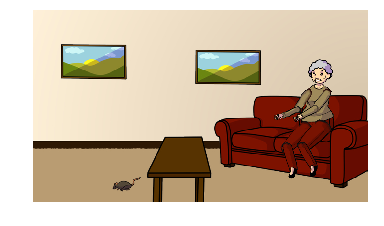

In [5]:
img = plt.imread(f"data/train/images/{data['file_name'].replace('png', 'jpg')}")
plt.imshow(img)
plt.axis('off');

In [6]:
scene = data['scene']
print(scene['sceneType'])

objects = scene['availableObject'] # list

Living-XinleiSubset


In [21]:
def parse_objects(objects):
    objs = []
    for i in range(len(objects)):
        object_instances = objects[i]['instance']
        for instance in object_instances:
            if instance['present']:
                objs.append([instance['name'], instance['x'], instance['y'], instance['z'], instance['flip'],
                             instance['typeID'] if 'typeID' in instance else instance['poseID'] if 'poseID' in instance else -1])
    return objs

In [9]:
parse_objects(objects)

[['Doll08', 585, 205, 2, 0, -1],
 ['Rat', 196, 364, 2, 0, 3],
 ['CoffeeTable', 306, 339, 2, 1, 1],
 ['Picture', 128, 109, 2, 0, 2],
 ['Picture', 409, 121, 2, 0, 2],
 ['Sofa', 554, 275, 2, 0, 1]]

In [28]:
for split in ['train', 'val']:
    img_path = []
    scene_type = []
    objects = []

    json_files = os.listdir(f"data/{split}/scene_composition_abstract_v002_{split}2015/")
    for i in tnrange(len(json_files)):
        with open(f"data/{split}/scene_composition_abstract_v002_{split}2015/{json_files[i]}") as f:
            data = json.load(f)

        img_path.append(f"data/{split}/images/{data['file_name'].replace('png', 'jpg')}")
        scene = data['scene']
        scene_type.append(scene['sceneType'])
        objects.append(parse_objects(scene['availableObject']))
    
    qa_df = pd.read_hdf(f'data/{split}/qa.h5').set_index('img_path')
    scene_df = pd.DataFrame({'img_path': img_path, 'scene_type': scene_type, 'objects': objects}).set_index('img_path')
    qa_df = qa_df.join(scene_df).reset_index()
    qa_df.to_hdf(f'data/{split}/qa.h5', 'multiple_choice')

A Jupyter Widget

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['img_path', 'answer', 'choices', 'question', 'objects', 'scene_type']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [29]:
train_qa = pd.read_hdf('data/train/qa.h5')
train_qa.head()

,img_path,answer,choices,question,objects,scene_type
0,data/train/images/abstract_v002_train2015_0000...,tan,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the ladies pants,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
1,data/train/images/abstract_v002_train2015_0000...,monkey bars,"[get warm, yes, playful, pug, red, fitness sys...",how is the equipments with bars called,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
2,data/train/images/abstract_v002_train2015_0000...,no,"[1, csi, real, n, red, solid, blocks and car, ...",is the bench a toy,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
3,data/train/images/abstract_v002_train2015_0000...,yes,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",is the woman on the couch sporting white hair,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset
4,data/train/images/abstract_v002_train2015_0000...,sitting,"[4, yellow, no, 2, reading, holding table, bar...",what is the woman doing,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset


In [30]:
val_qa = pd.read_hdf('data/val/qa.h5')
val_qa.head()

,img_path,answer,choices,question,objects,scene_type
0,data/val/images/abstract_v002_val2015_00000002...,orange,"[white, red, yellow, red and orange, red orang...",what color is the fire,"[[Kitten02, 472, 319, 2, 1, 3], [Rat, 593, 333...",Living-XinleiSubset
1,data/val/images/abstract_v002_val2015_00000002...,no,"[4, 3, above fireplace, brown, yes, 1, no, beh...",do the windows appear dirty,"[[Kitten02, 472, 319, 2, 1, 3], [Rat, 593, 333...",Living-XinleiSubset
2,data/val/images/abstract_v002_val2015_00000002...,yes,"[smiling, 4, for fun, no, forest, 3, sandwich ...",do the curtains match,"[[Kitten02, 472, 319, 2, 1, 3], [Rat, 593, 333...",Living-XinleiSubset
3,data/val/images/abstract_v002_val2015_00000002...,yes,"[no, brown, white, 4, no i think it looks more...",does the sidewalk suddenly disappear,"[[Chipmunk, 585, 247, 2, 0, 3], [Chipmunk, 618...",Park-XinleiSubset
4,data/val/images/abstract_v002_val2015_00000002...,under tree,"[2, off, 3, red, 1, yes, under tree, white, no...",where are the squirrel,"[[Chipmunk, 585, 247, 2, 0, 3], [Chipmunk, 618...",Park-XinleiSubset


In [35]:
scenes = train_qa.scene_type.unique()
scene_to_id = {scene: i for i, scene in enumerate(scenes)}
with open('data/scene_to_id.pkl', 'wb') as f:
    pickle.dump(scene_to_id, f)

In [41]:
object_names = set()
for objects in train_qa.objects:
    object_names.update([object[0] for object in objects])

object_to_id = {obj: i for i, obj in enumerate(object_names)}
with open('data/object_to_id.pkl', 'wb') as f:
    pickle.dump(object_to_id, f)

In [ ]:
objs = []
for i in range(len(obj_instance)):
    objs.extend([obj(o['part'], o['childX'], o['childY']) for o in obj_instance[i]['body']])
objs = list(set(objs))
objs

## Superpixels

In [92]:
imgg = img

Felzenszwalb number of segments: 738
SLIC number of segments: 10
Quickshift number of segments: 1652


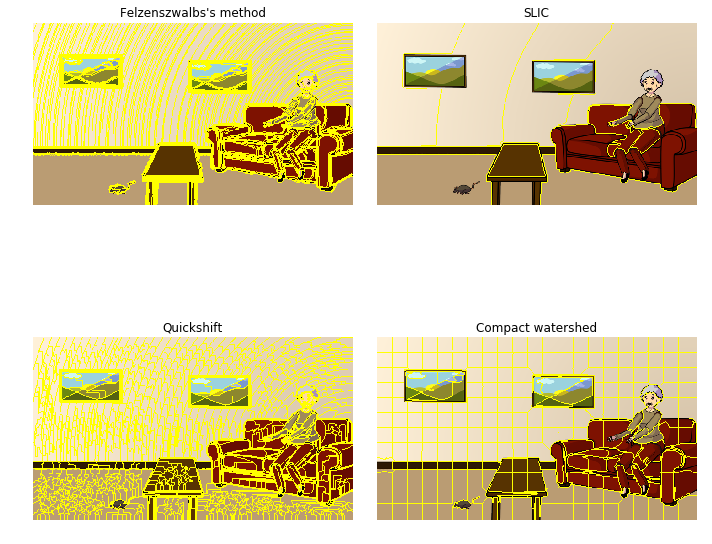

In [95]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = imgg[:, :, :-1]

segments_fz = felzenszwalb(img, scale=100, sigma=0.1, min_size=20)
segments_slic = slic(img, n_segments=20, compactness=1, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# VQATools Demo

In [56]:
split = 'train'

annotations_path = f'data/{split}/abstract_v002_train2015_annotations.json'
# questions_path = f'data/{split}/OpenEnded_abstract_v002_train2015_questions.json'
questions_path = 'data/train/MultipleChoice_abstract_v002_train2015_questions.json'
img_dir = f'data/{split}/images/'

vqa=VQA(annotations_path, questions_path) # initialize VQA api for QA annotations

loading VQA annotations and questions into memory...
0:00:02.241907
creating index...
index created!


Question: What animal is on the grass?
Answer 1: dog
Answer 2: dog
Answer 3: dog
Answer 4: cat
Answer 5: dog
Answer 6: dog
Answer 7: dog
Answer 8: dog
Answer 9: dog
Answer 10: cat


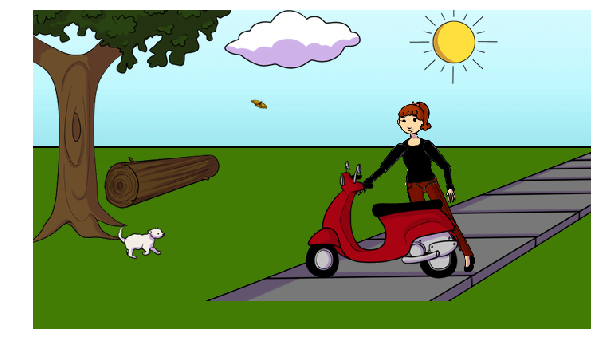

In [64]:
# load and display QA annotations for given question types
annotation_ids = vqa.getQuesIds()
annotations = vqa.loadQA(annotation_ids)
annotation = np.random.choice(annotations)
vqa.showQA([annotation])
img_id = annotation['image_id']

img_fname = f"data/{split}/images/abstract_v002_{split}2015_{str(img_id).zfill(12)}.jpg"

img = plt.imread(img_fname)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off');

* what color is (sometimes trickier like "the background of the photo on the wall")
* what animal is < present near an object>
* people's response to something < scared, ;
    * Need facial expression
* relative location (what is in front of ..., in the ground near ...)
* how many ... are there?
* Where is ... (e.g. right; right front; between bushes)
    * might want to know not only (x,y) of objects but also size of the whole image or dx, dy to the edges
* "Are the paintings all the same size"
    * Is it worth storing area of bounding box for each object?
* "Why is there a chair in the middle of the sofas?" Most common answer was "yes" (4)
* Scene characteristics (daytime; outside)
* Emotions (happy; upset; having fun)
* "Is there any healthy food?"

Question: Do you think the couple could have found a warmer place to get a picture taken?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: yes
Answer 9: yes
Answer 10: yes


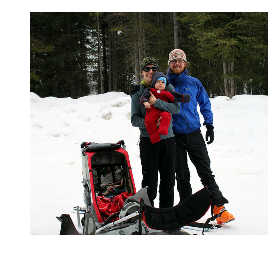

In [26]:
# load and display QA annotations for given answer types
# ansTypes can be one of the following: yes/no, number, other

annIds = vqa.getQuesIds(ansTypes='yes/no')
anns = vqa.loadQA(annIds)
randomAnn = np.random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(img_dir + imgFilename):
    I = plt.imread(img_dir + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Question: What is the route that this bus is running?
Answer 1: unsure
Answer 2: first route
Answer 3: downtown chicago
Answer 4: straight
Answer 5: city
Answer 6: bus route
Answer 7: london route
Answer 8: hop off
Answer 9: unknown
Answer 10: downtown


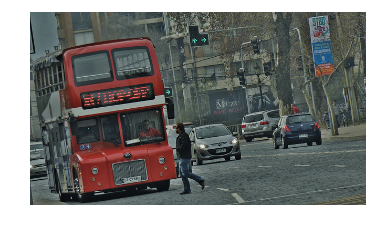

In [38]:
# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""

ids = vqa.getImgIds()
annIds = vqa.getQuesIds(imgIds=random.sample(ids,5));  
anns = vqa.loadQA(annIds)
randomAnn = np.random.choice(anns)
vqa.showQA([randomAnn])  
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(img_dir + imgFilename):
    I = plt.imread(img_dir + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

In [3]:
q = vqa.getQuesIds()

In [11]:
next(iter(vqa.qqa.keys()))

196608000

In [15]:
v = vqa.qqa.values()

In [16]:
v[0]

[{u'image_id': 196608,
  u'question': u'What is the person touching?',
  u'question_id': 196608000},
 {u'image_id': 265814,
  u'question': u'Is that a car?',
  u'question_id': 265814017},
 {u'image_id': 196608,
  u'question': u'What is on either side of the computer?',
  u'question_id': 196608002},
 {u'image_id': 196608,
  u'question': u'Is the laptop on?',
  u'question_id': 196608003},
 {u'image_id': 420479,
  u'question': u'Where would somebody walk?',
  u'question_id': 420479000},
 {u'image_id': 420479,
  u'question': u'Is this a harbor?',
  u'question_id': 420479001},
 {u'image_id': 420479,
  u'question': u'Are the boats sailing?',
  u'question_id': 420479002},
 {u'image_id': 158335,
  u'question': u'Are the donuts fresh?',
  u'question_id': 158335003},
 {u'image_id': 158335,
  u'question': u'How many sprinkles are on this donut?',
  u'question_id': 158335004},
 {u'image_id': 122527,
  u'question': u"What superhero is on the boy's hat?",
  u'question_id': 122527000},
 {u'image_id':

# Models
**Loading**
* Convert inputs to TFRecords?

**Preprocessing**
* Embed the words of the question using, e.g., Glove

**Pre-trained Models**
* Consider finding some RNN trained to do question answering already?

**Models**
* Compare concatenating the image and question embeddings vs multiplying them

**Training**


In [3]:
def question_to_ids(question: str, pad_to_length: int, word_to_id):
    unk_val = word_to_id['<UNK>']
    pad_val = word_to_id['<PAD>']
    assert pad_val == 0

    ids = [word_to_id.get(word, unk_val) for word in question.split(' ')]
    return ids + [pad_val] * (pad_to_length - len(ids))

def process_objects(objects, max_n_objects: int, object_to_id):
    objects = [[object_to_id[obj[0]], *obj[1:]] for obj in objects]
    return objects + [[0] * 6] * (max_n_objects - len(objects))

In [4]:
def load_data(add_scene_to_objects: bool=True, embed_object_names: bool=True, return_img_paths: bool=True) -> dict:
    with open('data/answer_to_id.pkl', 'rb') as f:
        answer_to_id = pickle.load(f)

    with open('data/word_to_id.pkl', 'rb') as f:
        word_to_id = pickle.load(f)

    with open('data/object_to_id.pkl', 'rb') as f:
        object_to_id = pickle.load(f)

    with open('data/scene_to_id.pkl', 'rb') as f:
        scene_to_id = pickle.load(f)

    train_qa = pd.read_hdf('data/train/qa.h5')
    val_qa = pd.read_hdf('data/val/qa.h5')

    # convert words and answers to ids
    max_question_length = train_qa.question.map(lambda question: len(question.split(' '))).max()

    train_questions = np.array(train_qa.question.map(lambda question: question_to_ids(question, max_question_length, word_to_id)).tolist())
    val_questions = np.array(val_qa.question.map(lambda question: question_to_ids(question, max_question_length, word_to_id)).tolist())

    unk_val = answer_to_id['<UNK>']
    train_answers = train_qa.answer.map(lambda answer: answer_to_id.get(answer, unk_val)).values
    val_answers = val_qa.answer.map(lambda answer: answer_to_id.get(answer, unk_val)).values

    train_img_paths = train_qa.img_path.values
    val_img_paths = val_qa.img_path.values

    max_n_objects = max(val_qa.objects.map(len).max(), train_qa.objects.map(len).max())

    # 0: name 1: x 2: y 3: z 4: flip 5: poseID 6: scene type, if added below
    train_objects = np.array(train_qa.objects.map(lambda objects: process_objects(objects, max_n_objects, object_to_id)).tolist())
    val_objects = np.array(val_qa.objects.map(lambda objects: process_objects(objects, max_n_objects, object_to_id)).tolist())

    train_scenes = train_qa.scene_type.map(scene_to_id.get).values
    val_scenes = val_qa.scene_type.map(scene_to_id.get).values

    if add_scene_to_objects:
        train_objects = np.concatenate((train_objects, np.repeat(train_scenes, max_n_objects).reshape(-1, max_n_objects, 1)), axis=-1)
        val_objects = np.concatenate((val_objects, np.repeat(val_scenes, max_n_objects).reshape(-1, max_n_objects, 1)), axis=-1)

    n_pose_ids = len(np.unique(train_objects[:, :, 5]))
    n_scene_types = len(np.unique(train_objects[:, :, 6]))

    # one-hot encode flip, poseID, and possibly object name; keep x, y, z as they are
    tf.reset_default_graph()
    sess = tf.Session(config=config)

    inp = tf.placeholder(tf.int32, (None, 56, 7))

    flip = tf.one_hot(inp[:, :, 4], 2)
    pose_id = tf.one_hot(inp[:, :, 5], n_pose_ids)
    transforms = [flip, pose_id]

    if add_scene_to_objects:
        scene_type = tf.one_hot(inp[:, :, 6], n_scene_types)
        transforms.append(scene_type)

    if not embed_object_names:
        object_names = tf.one_hot(inp[:, :, 0], max(object_to_id.values()))
        transforms.append(object_names)

    one_hot_inputs = tf.concat((*transforms, tf.cast(inp[:, :, 1:4], tf.float32)), axis=-1)
    train_objects_one_hot = sess.run(one_hot_inputs, {inp: train_objects})
    val_objects_one_hot = sess.run(one_hot_inputs, {inp: val_objects})

    train_inputs = {'question': train_questions, 'objects': train_objects_one_hot}
    val_inputs = {'question': val_questions, 'objects': val_objects_one_hot}

    if embed_object_names:
        train_inputs['object_names'] = train_objects[:, :, 0]
        val_inputs['object_names'] = val_objects[:, :, 0]

    if return_img_paths:
        train_inputs['img_paths'] = train_img_paths
        val_inputs['img_paths'] = val_img_paths

    return train_inputs, {'default': train_answers}, val_inputs, {'default': val_answers}

## Baselines

### Baseline 3: Img + Question + Given Objects

In [4]:
train_inputs, train_labels, val_inputs, val_labels = load_data()
img_shape = plt.imread(train_inputs['img_paths'][0]).shape # assumes all are the same shape

input_spec = {
    'question': (train_inputs['question'].shape[1:], 'int32'),
    'objects': (train_inputs['objects'].shape[1:], 'float32'),
    'object_names': (train_inputs['object_names'].shape[1:], 'int32'),
    'img': (img_shape, 'uint8')
}

In [54]:
def generator(inputs, labels, batch_size):
    img_paths = inputs['img_paths']
    idx = list(range(len(inputs['question'])))
    np.random.shuffle(idx)
    n_batches = int(np.ceil(len(idx) / batch_size))

    for batch in range(n_batches):
        batch_idx = idx[batch * batch_size : (batch + 1) * batch_size]
        batch_inputs = {key: val[batch_idx] for key, val in inputs.items() if key != 'img_paths'}
        batch_inputs['img'] = np.stack([plt.imread(path) for path in img_paths[batch_idx]])
        batch_labels = {key: val[batch_idx] for key, val in labels.items()}
        yield batch_inputs, batch_labels

batch_size = 64

train_generator = lambda : generator(train_inputs, train_labels, batch_size)
val_generator = lambda : generator(val_inputs, val_labels, batch_size)

In [55]:
tf.reset_default_graph()
tf.keras.backend.clear_session()

In [51]:
question_embedding_size = 150
object_embedding_size = 75
question_lstm_size = 128
objects_lstm_size = 256
dense_size = 512

vocab_size = len(np.unique(train_inputs['question']))
n_object_types = len(np.unique(train_inputs['object_names']))

layers = [
    [EmbeddingLayer(vocab_size, question_embedding_size, name='embed_question'), #  question: (batches x question_length)
     None,  # object_features: (batches x n_objects x n_object_features)
     EmbeddingLayer(n_object_types, object_embedding_size, name='embed_object'),  # object names (batches x )
     CustomLayer(lambda img: tf.image.convert_image_dtype(img, tf.float32))
    ],
    BranchedLayer([None,
                   MergeLayer(axis=-1),
                   CustomLayer(lambda img: tf.keras.applications.VGG19(include_top=False, input_tensor=img, pooling='avg').output)],
                  layer_input_map={0: [0], 1: [1, 2], 2: [3]}),
    [LSTMLayer(question_lstm_size, scope='lstm_question'), LSTMLayer(objects_lstm_size, scope='lstm_objects'), FlattenLayer()],
    DenseLayer(dense_size, batch_norm='')
]

layers = add_implied_layers(layers)

layers

[Branched [
 	<class 'tf_layers.layers.EmbeddingLayer'> [{'name': 'embed_question', 'shape': [4552, 150]}]
 	None
 	<class 'tf_layers.layers.EmbeddingLayer'> [{'name': 'embed_object', 'shape': [150, 75]}]
 	<class 'tf_layers.layers.CustomLayer'> [{}]
 ], Branched [
 	None
 	Merge[axis=-1]
 	<class 'tf_layers.layers.CustomLayer'> [{}]
 ], Branched [
 	LSTM[[128], tanh]
 	LSTM[[256], tanh]
 	<class 'tf_layers.layers.FlattenLayer'> [{}]
 ], Merge[axis=-1], Dense[512, relu]]

In [52]:
model_name = f'resnet50__qembed_{question_embedding_size}__oembed_{object_embedding_size}__qlstm_{question_lstm_size}__olstm_{objects_lstm_size}__dense_{dense_size}'

l2_lambda = None
# l2_lambda = .0001
# model_name += f"__l2_{l2_lambda}"

model = CNN(input_spec, layers, n_classes=len(np.unique(train_labels['default'])), config=config,
            model_name=model_name, models_dir='models', l2_lambda=l2_lambda, batch_size=batch_size,
#             record=False,
            overwrite_saved=True
           )

In [53]:
model.train(train_generator=train_generator, dev_generator=val_generator, verbose=1)

KeyboardInterrupt: 

In [ ]:
tf.keras.backend.set_learning_phase(1)

### Baseline 2: LSTM(Question) + LSTM(Given Objects Embedded)

In [14]:
train_inputs, train_labels, val_inputs, val_labels = load_data(return_img_paths=False)

input_data = {
    'question': (train_inputs['question'].shape[1:], 'int32'),
    'objects': (train_inputs['objects'].shape[1:], 'float32'),
    'object_names': (train_inputs['object_names'].shape[1:], 'int32')
}

In [15]:
tf.reset_default_graph()

question_embedding_size = 150
object_embedding_size = 75
vocab_size = len(np.unique(train_inputs['question']))
n_object_types = len(np.unique(train_inputs['object_names']))

layers = [
    # [question: (batches x question_length), object_features: (batches x n_objects x n_object_features)]
    [EmbeddingLayer(vocab_size, question_embedding_size, name='embed_question'), None,
     EmbeddingLayer(n_object_types, object_embedding_size, name='embed_object')],
    BranchedLayer([None, MergeLayer(axis=-1)], layer_input_map={0: [0], 1: [1, 2]}),
    [LSTMLayer(256, scope='lstm_question'), LSTMLayer(512, scope='lstm_objects')],
    DenseLayer(512, batch_norm='')
]

layers = add_implied_layers(layers)

layers

[Branched [
 	<class 'tf_layers.layers.EmbeddingLayer'> [{'name': 'embed_question', 'shape': [4552, 150]}]
 	None
 	<class 'tf_layers.layers.EmbeddingLayer'> [{'name': 'embed_object', 'shape': [150, 75]}]
 ], Branched [
 	None
 	Merge[axis=-1]
 ], Branched [
 	LSTM[[256], tanh]
 	LSTM[[512], tanh]
 ], Merge[axis=-1], Dense[512, relu]]

In [28]:
model_name = f'qembed_{question_embedding_size}__oembed_{object_embedding_size}__lstm_256__lstm_512__dense_512'

l2_lambda = .0001
model_name += f"__l2_{l2_lambda}"

model = CNN(input_data, layers, n_classes=len(np.unique(train_labels['default'])), config=config,
            model_name=model_name, models_dir='models', l2_lambda=l2_lambda,
#             record=False,
            overwrite_saved=True
           )

In [29]:
model.train(train_inputs, train_labels, val_inputs, val_labels, verbose=1)

Train loss: 2.942; Dev loss: 2.499. Metrics: {'acc_default': 0.40366668, 'dev_loss': 2.4988105, 'train_loss': 2.9422989, 'train_time': 1.7244721492131552, 'train_complete': False}. Time: 1.7421541889508565
Train loss: 2.328; Dev loss: 2.164. Metrics: {'acc_default': 0.44966668, 'dev_loss': 2.1636457, 'train_loss': 2.3279951, 'train_time': 3.4609935720761618, 'train_complete': False}. Time: 3.4777323603630066
Train loss: 2.062; Dev loss: 2.083. Metrics: {'acc_default': 0.46483332, 'dev_loss': 2.0833089, 'train_loss': 2.0622182, 'train_time': 5.194841130574544, 'train_complete': False}. Time: 5.213320541381836
Train loss: 1.922; Dev loss: 1.933. Metrics: {'acc_default': 0.48716667, 'dev_loss': 1.9328556, 'train_loss': 1.9222769, 'train_time': 6.932519169648488, 'train_complete': False}. Time: 6.947079952557882
Train loss: 1.830; Dev loss: 1.928. Metrics: {'acc_default': 0.48269999, 'dev_loss': 1.928357}. Time: 8.66633770863215
Train loss: 1.759; Dev loss: 1.889. Metrics: {'acc_default': 

{'acc_default': 0.51569998,
 'dev_loss': 1.9157413,
 'train_complete': True,
 'train_loss': 1.5071322,
 'train_time': 22.47309370835622}

### Baseline 1: LSTM(Question) + LSTM(Given Objects)

In [46]:
train_inputs, train_labels, val_inputs, val_labels = load_data(embed_object_names=False, return_img_paths=False)

input_data = {
    'question': (train_questions.shape[1:], 'int32'),
    'objects': (train_objects_one_hot.shape[1:], 'float32')
}

In [47]:
tf.reset_default_graph()

embedding_size = 150
vocab_size = len(word_to_id)

layers = [
    # [question: (batches x question_length), object_features: (batches x n_objects x n_object_features)]
    [EmbeddingLayer(vocab_size, embedding_size), None],
    [LSTMLayer(256, scope='lstm_question'), LSTMLayer(512, scope='lstm_objects')],
    DenseLayer(512, batch_norm='')
]

model_name = f'embed_{embedding_size}__lstm_256__lstm_512__dense_512__objects_onehot'

layers = add_implied_layers(layers)

layers

[Branched [
 	<class 'tf_layers.layers.EmbeddingLayer'> [{'name': 'embeddings', 'shape': [4552, 150]}]
 	None
 ], Branched [
 	LSTM[[256], tanh]
 	LSTM[[512], tanh]
 ], Merge[axis=-1], Dense[512, relu]]

In [49]:
model = CNN(input_data, layers, n_classes=len(np.unique(train_answers)), config=config,
            model_name=model_name, models_dir='models', record=False)

Loading graph from: models/embed_150__lstm_256__lstm_512__dense_512__objects_onehot/.


In [32]:
model.train({'question': train_questions, 'objects': train_objects_one_hot}, train_answers, {'question': val_questions, 'objects': val_objects_one_hot}, val_answers, verbose=1)

Train loss: 2.634; Dev loss: 2.227. Metrics: {'acc_default': 0.40703332, 'dev_loss': 2.227226, 'train_loss': 2.6341298, 'train_time': 1.6913782874743144, 'train_complete': False}. Time: 1.7086427847544352
Train loss: 2.113; Dev loss: 1.982. Metrics: {'acc_default': 0.44636667, 'dev_loss': 1.9822174, 'train_loss': 2.1129971, 'train_time': 3.4025733868281045, 'train_complete': False}. Time: 3.4187004884084065
Train loss: 1.875; Dev loss: 1.894. Metrics: {'acc_default': 0.46963334, 'dev_loss': 1.8942038, 'train_loss': 1.8750999, 'train_time': 5.110596875349681, 'train_complete': False}. Time: 5.127700920899709
Train loss: 1.710; Dev loss: 1.770. Metrics: {'acc_default': 0.49306667, 'dev_loss': 1.7702546, 'train_loss': 1.7101302, 'train_time': 6.821201288700104, 'train_complete': False}. Time: 6.837376753489177
Train loss: 1.587; Dev loss: 1.729. Metrics: {'acc_default': 0.49743333, 'dev_loss': 1.7293594, 'train_loss': 1.5866371, 'train_time': 8.528239321708678, 'train_complete': False}. T

{'acc_default': 0.52126664,
 'dev_loss': 1.9833542,
 'train_complete': True,
 'train_loss': 1.1166981,
 'train_time': 22.173019206523897}

## New Models

In [5]:
def soft_crop(img, names, xy):
    """
    :param img: placeholder(float32, (batches x img_height x img_width x channels))
    :param names: placeholder(int32, (batches x max_n_objects))
    :param xy: placeholder(float32, (batches x max_n_objects x 2))
    """

    with tf.name_scope('soft_crop'):
        img_height, img_width = img.shape.as_list()[1:3]
        n_samples = tf.shape(img)[0]
        max_n_objects = names.shape.as_list()[1]

        sigmas = tf.nn.embedding_lookup(tf.get_variable('object_sigmas', (n_object_types, 2), initializer=tf.constant_initializer(1)), names)

        gaussians_x = tf.distributions.Normal(xy[:, :, 0], sigmas[:, :, 0], name='gaussian_x')
        gaussians_y = tf.distributions.Normal(xy[:, :, 1], sigmas[:, :, 1], name='gaussian_y')

        x_coords = tf.range(0, img_width, dtype=tf.float32)
        y_coords = tf.range(0, img_height, dtype=tf.float32)

        x_coords = tf.tile(tf.reshape(x_coords, (img_width, 1, 1)), (1, n_samples, max_n_objects), name='x_coords')
        y_coords = tf.tile(tf.reshape(y_coords, (img_height, 1, 1)), (1, n_samples, max_n_objects), name='y_coords')

        x_weights = gaussians_x.prob(x_coords)
        y_weights = gaussians_y.prob(y_coords)

        x_weights /= tf.reduce_max(x_weights, axis=[1, 2], keep_dims=True)
        x_weights = tf.transpose(x_weights, [1, 2, 0])

        y_weights /= tf.reduce_max(y_weights, axis=[1, 2], keep_dims=True)
        y_weights = tf.transpose(y_weights, [1, 2, 0])

        # reshape everything to (batches x objects x height x width x channels)
        x_weights = tf.reshape(x_weights, (n_samples, max_n_objects, 1, img_width, 1))
        y_weights = tf.reshape(y_weights, (n_samples, max_n_objects, img_height, 1, 1))
        img_expanded = tf.expand_dims(img, 1)

        masked_imgs = img_expanded * x_weights * y_weights
        return masked_imgs

In [6]:
train_inputs, train_labels, val_inputs, val_labels = load_data()
object_limit = 16  # > 90% of cases covered in train
train_inputs = {key: val[:, :object_limit] if 'object' in key else val for key, val in train_inputs.items()}
val_inputs = {key: val[:, :object_limit] if 'object' in key else val for key, val in val_inputs.items()}
img_shape = plt.imread(train_inputs['img_paths'][0]).shape # assumes all are the same shape

In [11]:
def generator(inputs, labels, batch_size):
    img_paths = inputs['img_paths']
    idx = list(range(len(inputs['question'])))
    np.random.shuffle(idx)
    n_batches = int(np.ceil(len(idx) / batch_size))

    for batch in range(n_batches):
        batch_idx = idx[batch * batch_size : (batch + 1) * batch_size]
        batch_inputs = {key: val[batch_idx] for key, val in inputs.items() if key != 'img_paths'}
        batch_inputs['img'] = np.stack([plt.imread(path) for path in img_paths[batch_idx]])
        batch_labels = {key: val[batch_idx] for key, val in labels.items()}
        yield batch_inputs, batch_labels

batch_size = 32

train_generator = lambda : generator(train_inputs, train_labels, batch_size)
val_generator = lambda : generator(val_inputs, val_labels, batch_size)

In [12]:
question_embedding_size = 150
object_embedding_size = 75
question_lstm_size = 256
objects_lstm_size = 512
dense_size = 1024

vocab_size = len(np.unique(train_inputs['question']))
n_object_types = len(np.unique(train_inputs['object_names']))

input_spec = {
    'question': (train_inputs['question'].shape[1:], 'int32'),
    'objects': (train_inputs['objects'].shape[1:], 'float32'),
    'object_names': (train_inputs['object_names'].shape[1:], 'int32'),
    'img': (img_shape, 'uint8')
}

img_height, img_width = img_shape[:2]
max_n_objects = train_inputs['objects'].shape[1]

# input is questions
question_module = LayerModule([
    EmbeddingLayer(vocab_size, question_embedding_size, name='embed_question'),
    LSTMLayer(question_lstm_size, scope='lstm_question')
])

# input is [object_features, object_names]
objects_module = LayerModule([
    BranchedLayer([None, EmbeddingLayer(n_object_types, object_embedding_size, name='embed_object')]),
    MergeLayer(axis=-1)
])

# image section; split into global image processing, soft crops for objects, and final processing
divides_before_soft_crop = 5  # all assumed to be 2x2 reductions

img_before_softcrop = LayerModule([
    CustomLayer(lambda img: tf.image.convert_image_dtype(img, tf.float32)),
    ConvLayer(32, 3, strides=2),
    ConvLayer(64, 3, strides=2),
    ConvLayer(128, 3, strides=2),
    ConvLayer(256, 3, strides=2),
    ConvLayer(512, 3, strides=2),
])

img_after_softcrop = LayerModule([
    ConvLayer(512, 3, strides=2),
    GlobalAvgPoolLayer(),
    FlattenLayer(),
])

# input is [img, object_names, object_features (for xy data)]
img_module = LayerModule([
    BranchedLayer([img_before_softcrop, None, None]),
    CustomLayer(lambda inputs: soft_crop(inputs[0], inputs[1], inputs[2][:, :, -3:-1] / 2 ** divides_before_soft_crop)),
    CustomLayer(lambda img: tf.reshape(img, (-1, *img.shape.as_list()[2:]))),  # put object dim into the batch dimension 
    img_after_softcrop,
    CustomLayer(lambda img: tf.reshape(img, (-1, max_n_objects, img.shape[-1].value)))  # bring object dim back from the batch dimension
])

layers = [
    BranchedLayer([question_module, objects_module, img_module], layer_input_map={0: [0], 1: [1, 2], 2: [3, 2, 1]}),
    BranchedLayer([None, MergeLayer(axis=-1)], layer_input_map={0: [0], 1: [1, 2]}),
    [None, LSTMLayer(objects_lstm_size)],
    DenseLayer(dense_size, batch_norm='')
]

layers = add_implied_layers(layers)

layers

[Branched [
 	<class 'tf_layers.layers.LayerModule'> [{}]
 	<class 'tf_layers.layers.LayerModule'> [{}]
 	<class 'tf_layers.layers.LayerModule'> [{}]
 ], Branched [
 	None
 	Merge[axis=-1]
 ], Branched [
 	None
 	LSTM[[512], tanh]
 ], Merge[axis=-1], Dense[1024, relu]]

In [15]:
model_name = f'test_cnn__qembed_{question_embedding_size}__oembed_{object_embedding_size}__qlstm_{question_lstm_size}__olstm_{objects_lstm_size}__dense_{dense_size}'

l2_lambda = None
# l2_lambda = 2
# model_name += f"__ml2_{l2_lambda}"

model = NN(input_spec, layers, n_classes=len(np.unique(train_labels['default'])), config=config,
            model_name=model_name, models_dir='models', l2_lambda=l2_lambda, batch_size=batch_size,
            modified_l2=True,
#             record=False,
#             overwrite_saved=True
           )

In [16]:
model.train(train_generator=train_generator, dev_generator=val_generator, verbose=3, n_train_batches_per_epoch=25, n_dev_batches_per_epoch=5, n_epochs=100, max_patience=20)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

{'acc_default': 0.44999999,
 'dev_loss': 2.7369561,
 'train_complete': True,
 'train_loss': 3.140017,
 'train_time': 6.2487850745519005}

In [ ]:
model.graph.

In [ ]:
# change tensor_attributes to save learning rate

In [17]:
with model.graph.as_default():
    tf.assign(model.learning_rate, .0001)

AttributeError: 'float' object has no attribute 'dtype'

In [14]:
model.train(train_generator=train_generator, dev_generator=val_generator, verbose=3, n_train_batches_per_epoch=25, n_dev_batches_per_epoch=5, n_epochs=100, max_patience=20)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

NameError: name 'CNN' is not defined

In [ ]:
# switch to GlobalMaxPool

In [ ]:
# 1.6 s/batch (8)

### Soft crop testing

In [ ]:
# number of objects in each image can be different... how to do all of the convolutions over each image efficiently? could stack everything into the batch dimension and then just
# reshape properly at the end? as long as we keep track of how many images were for each sample. E.g. for 2 samples with 4 and 5 objects, we end up with 9 stacked images that we
# pass through the conv layers. At the end we reshape to get the batch dimension back to size 2 and instead of 4/5 "timesteps". Ah, but that still won't work without some padding...

# can we just store things as a list of Tensors instead of putting that last dimension into being a tensor too? So have a list of [4 tensors, 5 tensors] above

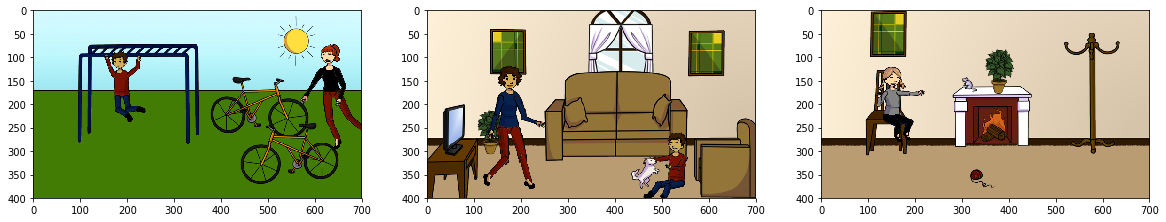

In [297]:
idx = np.random.choice(range(len(train_inputs['img_paths'])), 3)

imgs = np.stack([plt.imread(path) / 255 for path in train_inputs['img_paths'][idx]])

plt.figure(figsize=(20, 20))
for i in range(len(imgs)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[i])

In [298]:
tf.reset_default_graph()
sess = tf.Session(config=config)

In [299]:
img_height = img_shape[0]
img_width = img_shape[1]
max_n_objects = 56

In [300]:
img_p = tf.placeholder(tf.float32, (None, *imgs[0].shape))
names_p = tf.placeholder(tf.int32, (None, *train_inputs['object_names'].shape[1:]))
xy_p = tf.placeholder(tf.float32, (None, max_n_objects, 2))

img_p, names_p, xy_p

(<tf.Tensor 'Placeholder:0' shape=(?, 400, 700, 3) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(?, 56) dtype=int32>,
 <tf.Tensor 'Placeholder_2:0' shape=(?, 56, 2) dtype=float32>)

In [301]:
sigmas = tf.nn.embedding_lookup(tf.get_variable('object_sigmas', (n_object_types, 2), initializer=tf.constant_initializer(35)), names_p)
sigmas

<tf.Tensor 'embedding_lookup:0' shape=(?, 56, 2) dtype=float32>

In [302]:
gaussians_x = tf.distributions.Normal(xy_p[:, :, 0], sigmas[:, :, 0])
gaussians_y = tf.distributions.Normal(xy_p[:, :, 1], sigmas[:, :, 1])

x_coords = tf.range(0, img_width, dtype=tf.float32)
y_coords = tf.range(0, img_height, dtype=tf.float32)

n_samples = tf.shape(img_p)[0]

x_coords = tf.tile(tf.reshape(x_coords, (img_width, 1, 1)), (1, n_samples, max_n_objects))
y_coords = tf.tile(tf.reshape(y_coords, (img_height, 1, 1)), (1, n_samples, max_n_objects))

In [303]:
x_weights = gaussians_x.prob(x_coords)
y_weights = gaussians_y.prob(y_coords)

In [304]:
x_weights /= tf.reduce_max(x_weights, axis=[1, 2], keep_dims=True)
x_weights = tf.transpose(x_weights, [1, 2, 0])

y_weights /= tf.reduce_max(y_weights, axis=[1, 2], keep_dims=True)
y_weights = tf.transpose(y_weights, [1, 2, 0])

In [305]:
x_weights, y_weights

(<tf.Tensor 'transpose:0' shape=(?, 56, 700) dtype=float32>,
 <tf.Tensor 'transpose_1:0' shape=(?, 56, 400) dtype=float32>)

In [306]:
# reshape everything to (batches x objects x height x width x channels)
x_weights = tf.reshape(x_weights, (n_samples, max_n_objects, 1, img_width, 1))
y_weights = tf.reshape(y_weights, (n_samples, max_n_objects, img_height, 1, 1))
img_expanded = tf.expand_dims(img_p, 1)

In [307]:
x_weights, y_weights, img_expanded

(<tf.Tensor 'Reshape_2:0' shape=(?, 56, 1, 700, 1) dtype=float32>,
 <tf.Tensor 'Reshape_3:0' shape=(?, 56, 400, 1, 1) dtype=float32>,
 <tf.Tensor 'ExpandDims:0' shape=(?, 1, 400, 700, 3) dtype=float32>)

In [308]:
masked_imgs = img_expanded * x_weights * y_weights
masked_imgs

<tf.Tensor 'mul_1:0' shape=(?, 56, 400, 700, 3) dtype=float32>

In [309]:
sess.run(tf.global_variables_initializer())

In [310]:
ret = sess.run(masked_imgs, {img_p: imgs, xy_p: train_inputs['objects'][idx, :, -3:-1], names_p: train_inputs['object_names'][idx]})
ret.shape

(3, 56, 400, 700, 3)

In [331]:
obj_num = -1

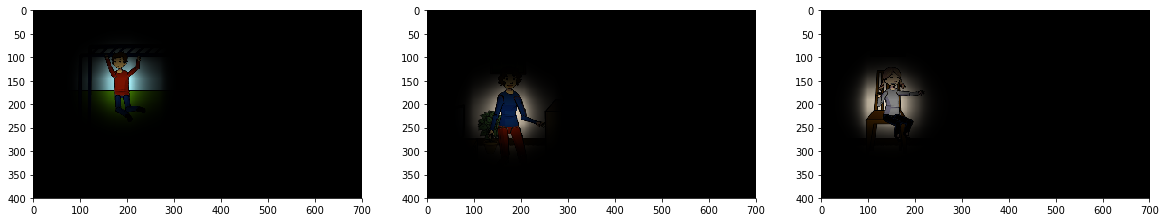

In [332]:
obj_num += 1

plt.figure(figsize=(20, 20))
for i in range(len(ret)):
    plt.subplot(1, 3, i + 1)
    
    plt.imshow(ret[i, obj_num])

## Comparison

acc | model
--- | ---
.511 | Embed(?), 2x LSTM(16), Dense(32); just object + question

# Scratch

In [35]:
sum([np.product(var.shape.as_list()) for var in model.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])

3976233

In [25]:
sum([np.product(var.shape.as_list()) for var in model.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[1:]])

53353

In [ ]:
tf.keras.layers.LSTM()

In [ ]:
# use tf to run the conversion once, ahead of time, so you don't have to put all of this in the graph
# or redo it every time that you feed a batch in
# ah, you could do the one-hot conversion ahead of time, but if you want to do an embedding, you'll need
# that to be in the graph
# could feed object_names in as a separate input so that you can do an initial EmbeddingLayer on it
# (probably need to Branch so that you can do a no-op on the others)

In [75]:
batch_size = 128
embedding_size = 300
img_size = (500, 500)
n_lstm_units = 512

# csv.QUOTE_NONE = 3; this makes it so things like " are parsed as words instead of as the start of a string
embeddings = pd.read_csv('data/glove.6B.{}d.txt'.format(embedding_size), sep=' ', index_col=0, header=None, quoting=3)
padding = '@PADDING@'
embeddings = pd.concat([embeddings, pd.DataFrame([[0] * embedding_size], index=[padding], columns=embeddings.columns)])

question_ids = vqa.getQuesIds()
questions = [preprocess_question(vqa.qqa[question_id]['question']).split(' ') for question_id in question_ids]

# pad all questions to same length
max_question_length = max(len(question) for question in questions)
questions = np.array([question + [padding] * (max_question_length - len(question)) for question in questions])

In [76]:
tf.reset_default_graph()

In [77]:
images = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='raw_images') # batch x height x width x channels
images = tf.image.resize_images(images, size=img_size)

cnn = tf.contrib.keras.applications.ResNet50(include_top=False, input_tensor=images)
img_embedding = tf.reshape(cnn.output, shape=(-1, np.product(cnn.output.shape.as_list()[1:])))
img_embedding

<tf.Tensor 'Reshape:0' shape=(?, 8192) dtype=float32>

In [78]:
questions_p = tf.placeholder(tf.float32, shape=(None, max_question_length, embedding_size), name='embedded_questions')

rnn_cells = tf.contrib.rnn.LSTMCell(n_lstm_units)
outputs, state = tf.nn.dynamic_rnn(rnn_cells, questions_p, dtype=tf.float32, parallel_iterations=batch_size)

# TODO: fix this to actually get the last relevant output; use state too or only output?
last_output = outputs[:, -1, :]
last_output

<tf.Tensor 'strided_slice:0' shape=(?, 512) dtype=float32>

In [80]:
img_and_question = tf.concat([img_embedding, last_output], axis=1)
img_and_question

<tf.Tensor 'concat_1:0' shape=(?, 8704) dtype=float32>

In [81]:
n_classes = 1000
hidden = tf.layers.dense(img_and_question, 1024, activation=tf.nn.relu)
output = tf.layers.dense(hidden, n_classes)

In [ ]:
tf.contrib.keras.applications.VGG16()

In [ ]:
batch_questions = questions[:batch_size]
embedded_questions = embeddings.loc[batch_questions.ravel()].values.reshape(-1, max_question_length, embedding_size)